In [1]:
# Import the required libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from IPython.display import Audio

In [2]:
import random
# This function creates a pure sine wave
def create_sin_wave(freq, num_samples, sample_rate):
    time = np.linspace(0, num_samples/sample_rate, num_samples)
    wave_data = 0
    for v in range(1,10):
         wave_data += np.sin((2*v*np.pi*freq)*time)
    return time, wave_data
    
# This function creates a pure cosine wave (Implement this one yourself)
def create_cos_wave(freq, num_samples, sample_rate):
	raise NotImplementedError("Implement create_cos_wave yourself!")
    
# This function plots a graph
def plot_graph(x, y=None, label=None, title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if y is not None:
        plt.plot(x, y, label=label)
    else:
        plt.plot(x, label)
    return plt.legend()


In [3]:
# A pure sine wave created at concert A (440Hz) that is 2 seconds long
SAMPLE_RATE = 16_000
T, audio_440 = create_sin_wave(440, 2*SAMPLE_RATE, SAMPLE_RATE)
Audio(audio_440, rate=SAMPLE_RATE)

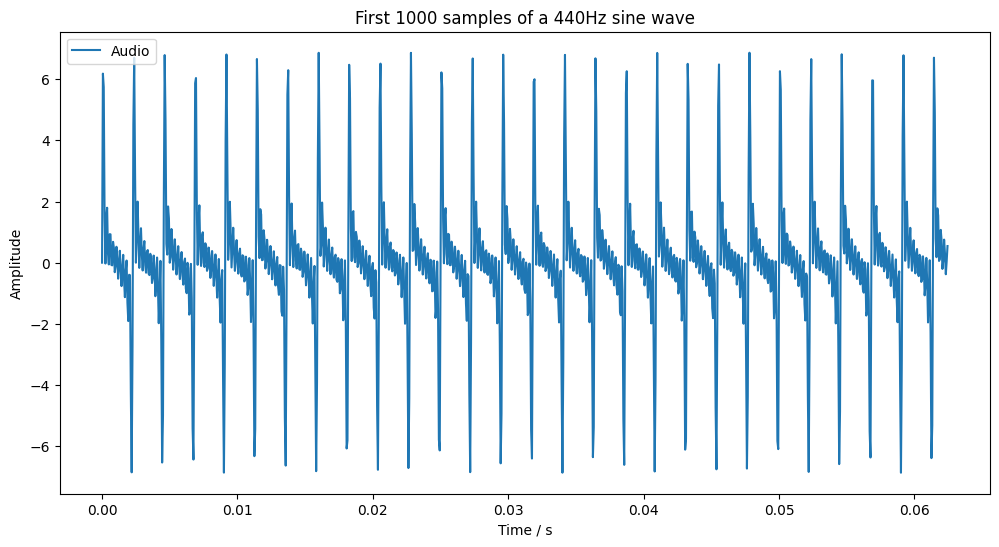

In [4]:
plot_graph(T[:1000], audio_440[:1000], "Audio", "First 1000 samples of a 440Hz sine wave", "Time / s", "Amplitude")

## A side note about sampling
You might be wondering about the sample_rate. What difference does it make to your audio?
Well, the bigger it is, the more data you have to store and process, so you want to keep it as small as possible.
But as you decrease the sample_rate, you lose information about your physical signal as you have no idea what values it takes on in between the sample points. So what's the middle ground? The answer is found in the Nyquist-Shannon theorem, which states that only frequencies less than $\frac{f_s}{2}$ are preserved, where $f_s$ is your sampling frequency. 
<div class="alert alert-block alert-info"><b>Exercise:</b> Suggest why the standard sampling rate for modern audio (CDs etc.) is 44.1kHz</div>

# Implementing a Fourier Transform
We are going to take the theory covered so far and implement our own Discrete Fourier Transform! A reminder of the Fourier transform:
$$ \hat{f}(k) = \int_{-\infty}^{\infty} f(x) e^{-ikx} \mathrm{d}x $$
<div class="alert alert-block alert-info"><b>Exercise:</b> Seperate this function into real and imaginary componenets. Use this to fill in the first two functions below. Finally, use these to calculate the magnitude of the Fourier Transform $|\hat{f}(k)|$. <br/> <b>Tip:</b> Use the <code>np.trapezoid</code> function to calculate the integral, with the appropriate <code>dx</code> parameter. </div>

In [5]:
import math
# changes:
# - removed x2 in integral formula
# - dx is 1/rate

# Calculate the real component of the Fourier Transform 
def calculate_real(data, k, rate):
    a_k = np.trapezoid([data[n]*math.cos(-(k*4*math.pi*n)/(len(data)))for n in range(len(data))], dx=1/rate)
    return a_k

# Calculate the imaginary component of the Fourier Transform
def calculate_imag(data, k, rate):
    b_k = np.trapezoid([data[x]*math.sin(-(k*4*math.pi*x)/(len(data))) for x in range(len(data))], dx=1/rate)
    return b_k

# Calculate the magnitude of the Fourier Transform
def calculate_mag(data, k, rate):
    return math.sqrt(calculate_real(data, k, rate)**2+calculate_imag(data, k, rate)**2)
    raise NotImplementedError("Implement calculate_mag yourself!")

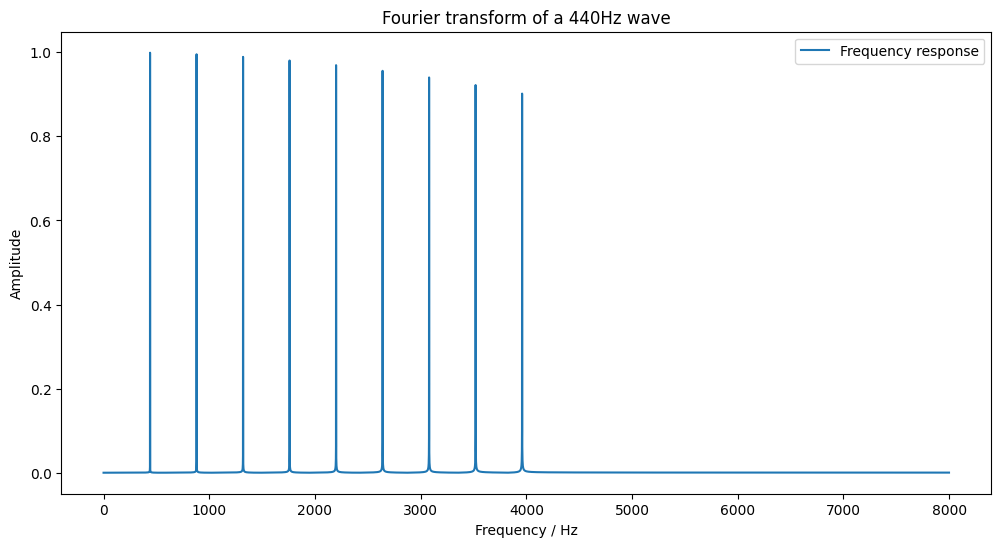

In [6]:
F = list(range(0, SAMPLE_RATE//2))
fourier_transform_440 = [calculate_mag(audio_440, k, SAMPLE_RATE) for k in F]
plot_graph(F, fourier_transform_440, "Frequency response", "Fourier transform of a 440Hz wave", "Frequency / Hz", "Amplitude")

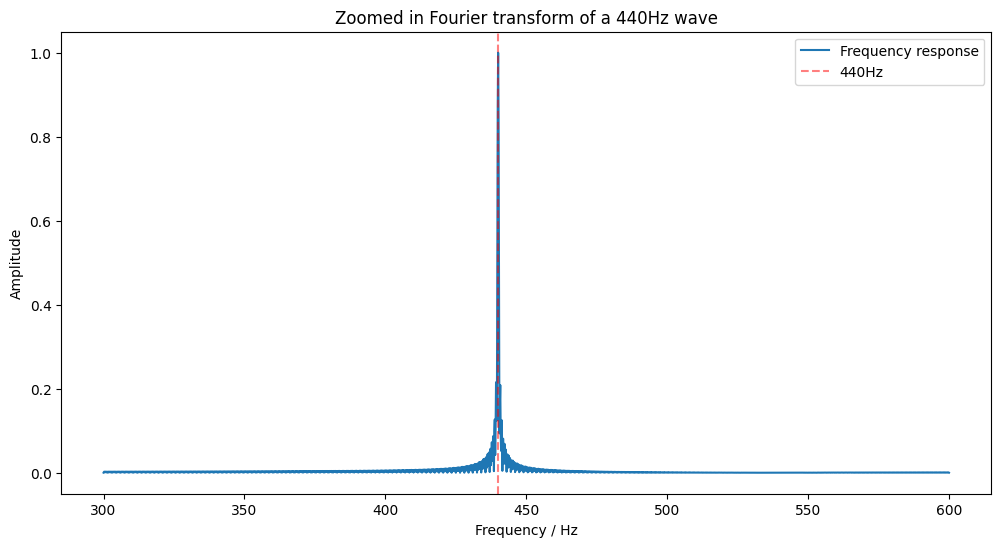

In [7]:
# Let's zoom in on our region of interest
F_ZOOMED = np.linspace(300, 600, 2000)
fourier_transform_440_zoomed = [calculate_mag(audio_440, k, SAMPLE_RATE) for k in F_ZOOMED]
plot_graph(F_ZOOMED, fourier_transform_440_zoomed, "Frequency response", "Zoomed in Fourier transform of a 440Hz wave", "Frequency / Hz", "Amplitude")
plt.axvline(440, color="red", ls="--", alpha=0.5, label="440Hz")
plt.legend()

If all has gone well, we can see that we are sharply peaked around the frequency of the tone. The higher our sampling frequency, the more sharply peaked the function will be. Since we just had a pure sine wave as input, this is exactly the function we expect: there are no other frequencies present. Let's try a more complex example.


In [8]:
rate, big_data = wavfile.read("../voice-sample.wav")
big_data_cut = big_data[rate * 5:rate * 8] # Take the 5 - 9 second range
Audio(big_data_cut, rate=rate)

In [9]:
F = list(range(0, rate//2))
big_fourier_transform = [calculate_mag(big_data_cut, k, rate) for k in F]

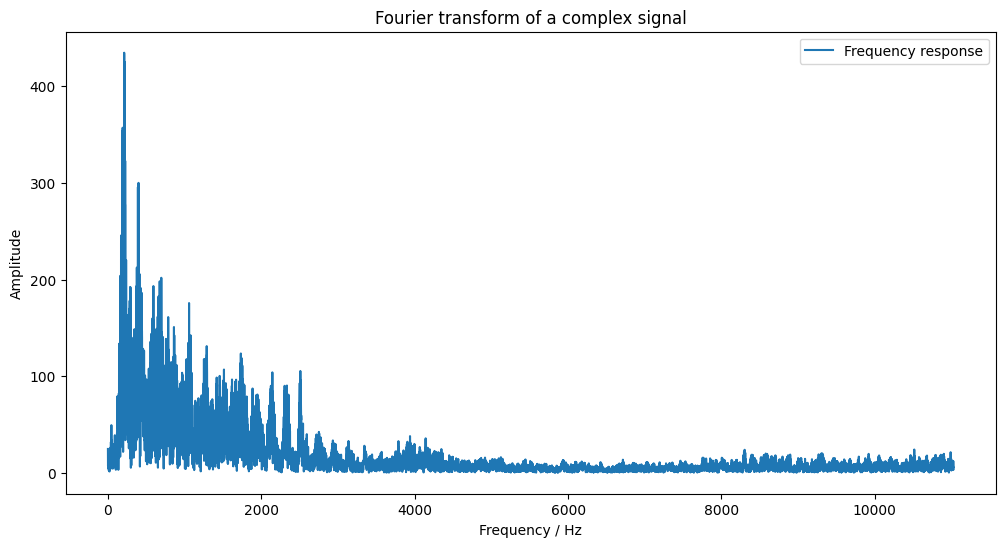

In [ ]:
plot_graph(F, big_fourier_transform, "Frequency response", "Fourier transform of a complex signal", "Frequency / Hz", "Amplitude")

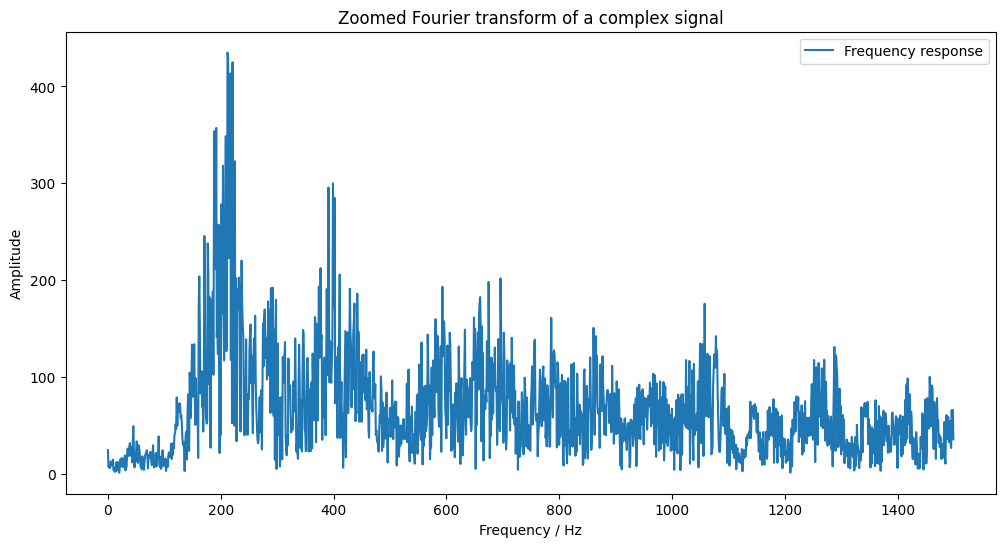

In [ ]:
plot_graph(F[:1500], big_fourier_transform[:1500], "Frequency response", "Zoomed Fourier transform of a complex signal", "Frequency / Hz", "Amplitude")

This is clearly a more complicated signal, but there is a definite peak at ~130Hz. The peak at ~260Hz is likely to be a **harmonic**. Physical systems (like voices and instruments) tend to produce sound through vibrations, and waves which are multiples of the fundamental frequency tend to also be present. Let's test whether our Fourier Transform is correct by testing against the FFT (Fast Fourier Transform) available in the `scipy` package.


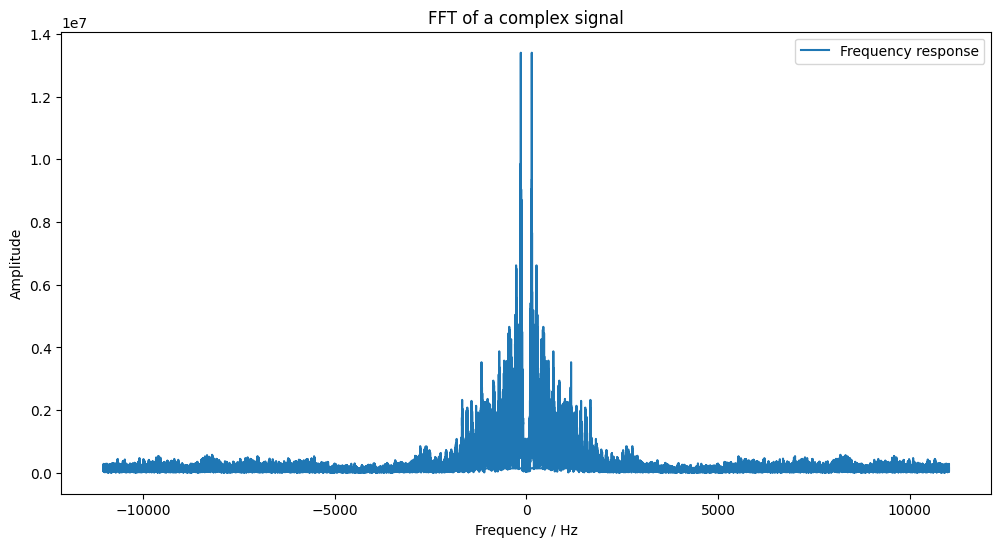

In [ ]:
big_fft = np.abs(fft(big_data_cut))
freqs = fftfreq(len(big_data_cut), 1/rate)
plot_graph(freqs, big_fft, "Frequency response", "FFT of a complex signal", "Frequency / Hz", "Amplitude")

This looks about the same as our graph, which is good! However, the Scipy FFT also contains negative frequencies, and this output is symmetric.
<div class="alert alert-block alert-info"><b>Exercise:</b> Show that the Fourier Transform of a real-valued function is <b>Hermitian</b> i.e. $\hat{f}(-k)=\overline{\hat{f}(k)}$. Use this to explain why the output is symmetric. </div>
Going forwards, we will use the Scipy <code>rfft</code> function as it is optimised for speed and only produces the positive frequency spectrum.